In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("pastel")

# %% [markdown]
# ## Data Loading

# %%
# Load datasets (replace with your actual file paths)
playstore_df = pd.read_csv("F:/Oasis Infobyte_internship/Unveiling the Android App Market Analyzing Google Play Store Data/apps.csv")  # First file
reviews_df = pd.read_csv("F:/Oasis Infobyte_internship/Unveiling the Android App Market Analyzing Google Play Store Data/user_reviews.csv")  # Second file

# Display samples
print("Play Store Data - First 5 rows:")
display(playstore_df.head())
print("\nUser Reviews Data - First 5 rows:")
display(reviews_df.head())

Play Store Data - First 5 rows:


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up



User Reviews Data - First 5 rows:


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [5]:
def clean_playstore_data(df):
    """Clean and preprocess the play store dataset"""
    
    # Handle duplicates
    df = df.drop_duplicates(subset='App', keep='first')
    
    # Convert 'Last Updated' to datetime
    df['Last Updated'] = pd.to_datetime(df['Last Updated'])
    
    # Clean 'Size' column
    df['Size'] = df['Size'].str.replace('Varies with device', 'NaN')
    df['Size'] = df['Size'].str.replace('M', 'e6').str.replace('k', 'e3')
    df['Size'] = pd.to_numeric(df['Size'], errors='coerce')
    df['Size'] = df['Size'] / 1e6  # Convert to MB
    
    # Clean 'Installs'
    df['Installs'] = df['Installs'].str.replace('+', '').str.replace(',', '')
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    
    # Clean 'Price'
    df['Price'] = df['Price'].str.replace('$', '')
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    # Convert 'Reviews' to numeric
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    
    # Handle missing ratings
    df['Rating'] = df.groupby('Category')['Rating'].transform(
        lambda x: x.fillna(x.median()))
    
    
    # Clean 'Type' column
    df['Type'] = df['Type'].replace({'0': 'Free', 'NaN': 'Free'})
    
    return df

playstore_df = clean_playstore_data(playstore_df)

def clean_reviews_data(df):
    """Clean and preprocess the user reviews dataset"""
    
    # Fill missing sentiment polarity with neutral (0)
    df['Sentiment_Polarity'] = df['Sentiment_Polarity'].fillna(0)
    
    # Fill missing subjectivity with median
    df['Sentiment_Subjectivity'] = df['Sentiment_Subjectivity'].fillna(
        df['Sentiment_Subjectivity'].median())
    
    # Fill missing sentiment with 'Neutral'
    df['Sentiment'] = df['Sentiment'].fillna('Neutral')
    
    # Drop rows with missing reviews
    df = df.dropna(subset=['Translated_Review'])
    
    return df

reviews_df = clean_reviews_data(reviews_df)


# Merge datasets
merged_df = pd.merge(playstore_df, reviews_df, on='App', how='left')

# Display cleaned data info
print("\nCleaned Play Store Data Info:")
playstore_df.info()
print("\nCleaned Reviews Data Info:")
reviews_df.info()


Cleaned Play Store Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      9659 non-null   int64         
 1   App             9659 non-null   object        
 2   Category        9659 non-null   object        
 3   Rating          9659 non-null   float64       
 4   Reviews         9659 non-null   int64         
 5   Size            8432 non-null   float64       
 6   Installs        9659 non-null   int64         
 7   Type            9658 non-null   object        
 8   Price           9659 non-null   float64       
 9   Content Rating  9659 non-null   object        
 10  Genres          9659 non-null   object        
 11  Last Updated    9659 non-null   datetime64[ns]
 12  Current Ver     9651 non-null   object        
 13  Android Ver     9657 non-null   object        
dtypes: datetime64[ns](1), flo

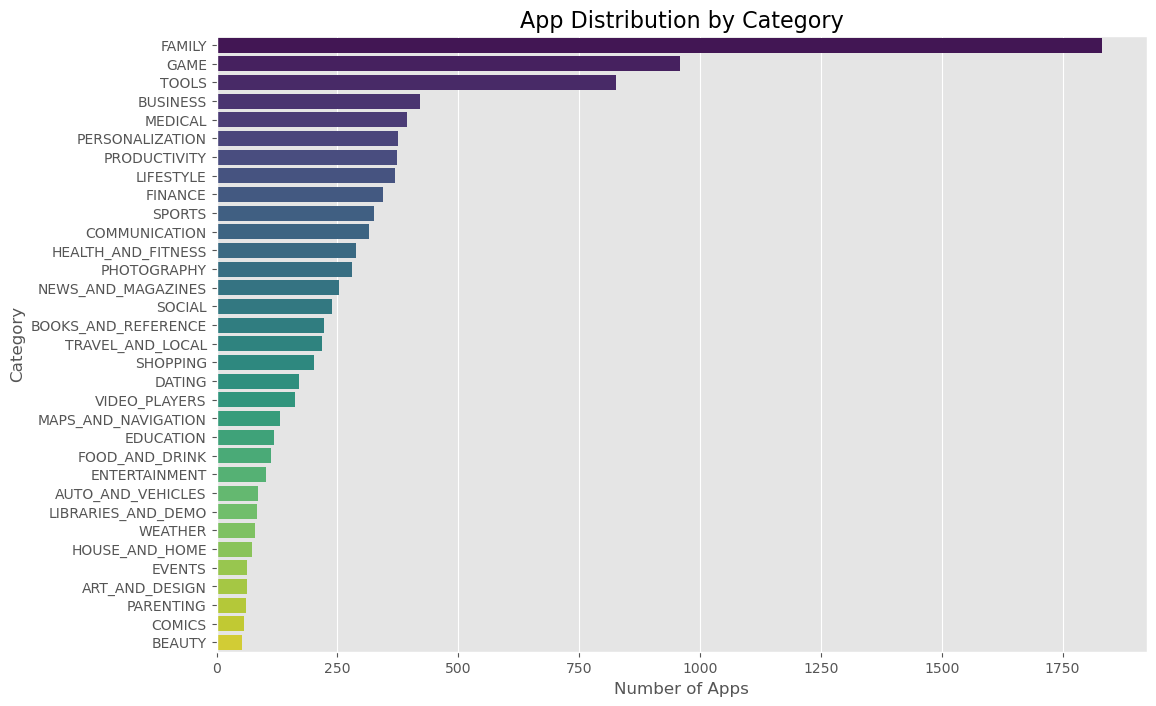

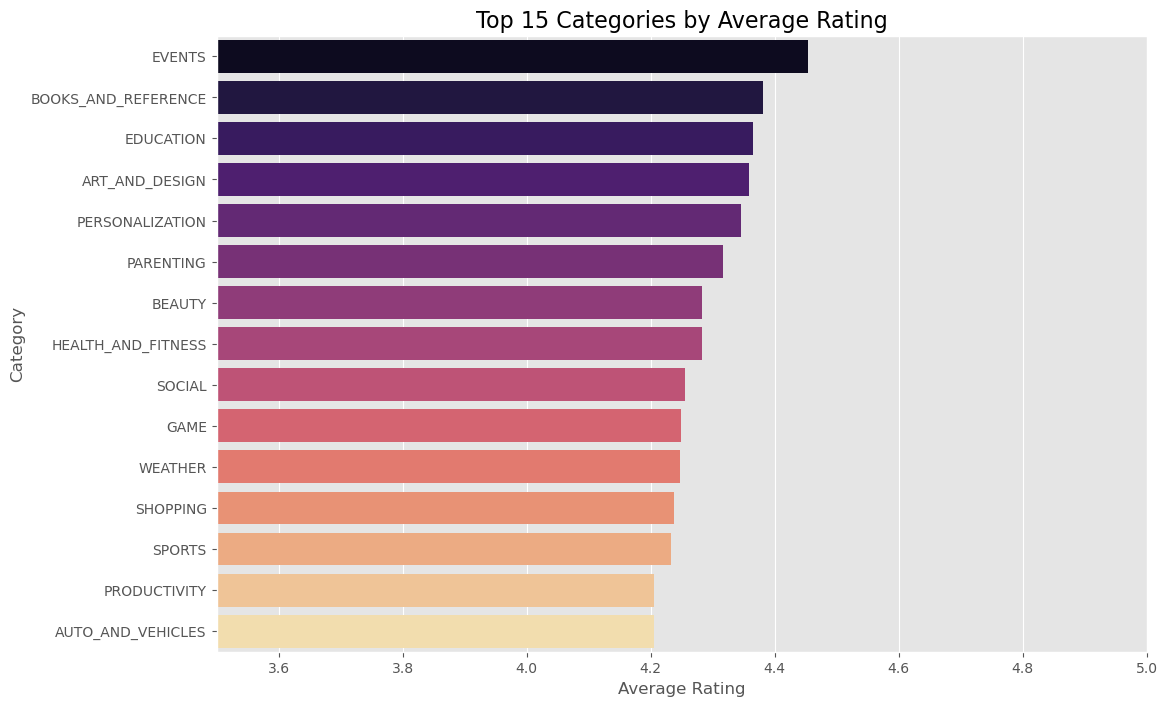

In [9]:
# ## Category Exploration


# App distribution by category
plt.figure(figsize=(12, 8))
category_counts = playstore_df['Category'].value_counts().sort_values(ascending=False)
sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')
plt.title('App Distribution by Category', fontsize=16)
plt.xlabel('Number of Apps', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# Top categories by average rating
plt.figure(figsize=(12, 8))
category_ratings = playstore_df.groupby('Category')['Rating'].mean().sort_values(ascending=False)[:15]
sns.barplot(x=category_ratings.values, y=category_ratings.index, palette='magma')
plt.title('Top 15 Categories by Average Rating', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xlim(3.5, 5)
plt.show()

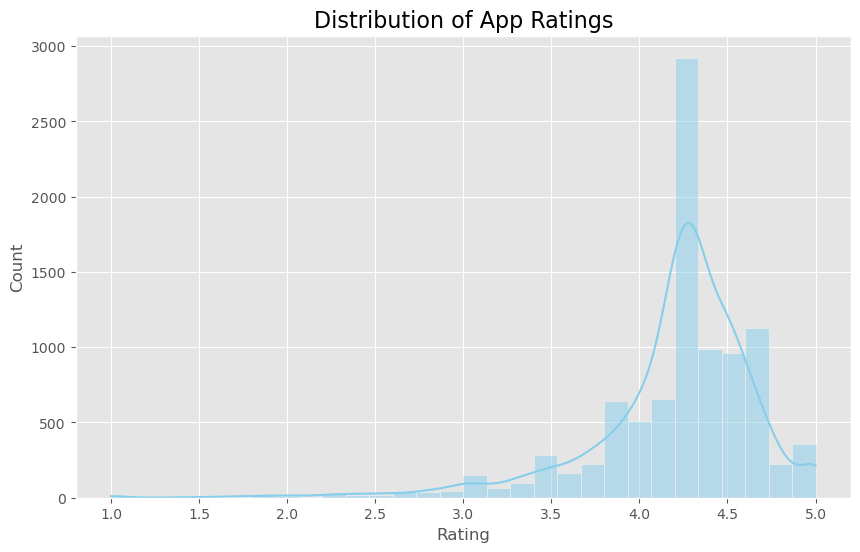

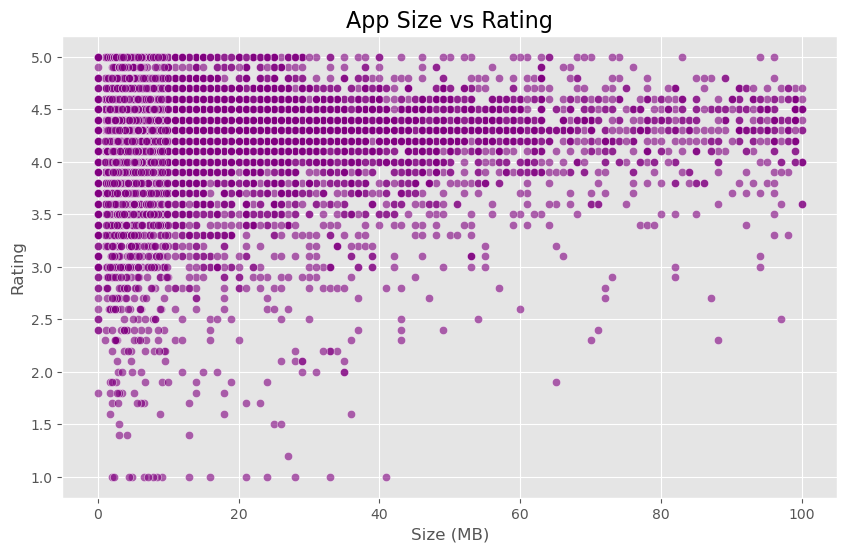

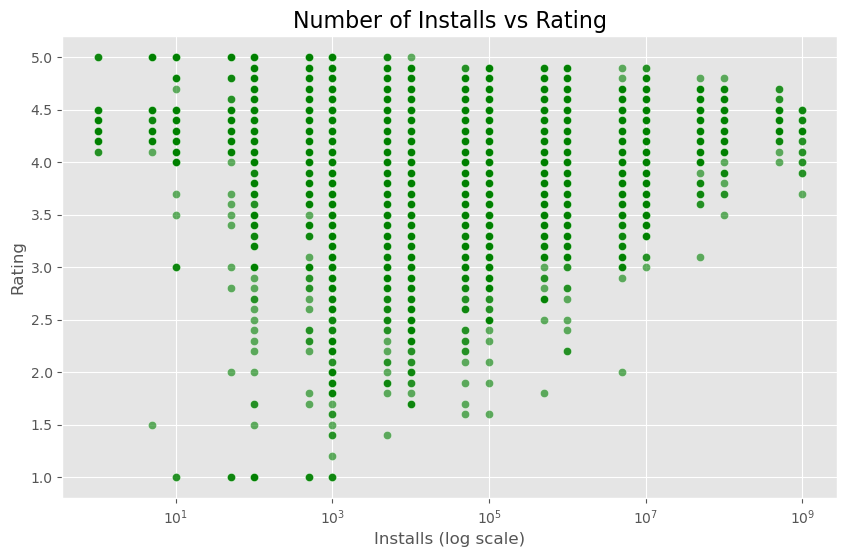

In [11]:



# ## Metrics Analysis


# Rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(playstore_df['Rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of App Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


# Size vs Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Size', y='Rating', data=playstore_df, alpha=0.6, color='purple')
plt.title('App Size vs Rating', fontsize=16)
plt.xlabel('Size (MB)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()


# Installs vs Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Installs', y='Rating', data=playstore_df, alpha=0.6, color='green')
plt.title('Number of Installs vs Rating', fontsize=16)
plt.xlabel('Installs (log scale)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xscale('log')
plt.show()




In [ ]:
# Price analysis
paid_apps = playstore_df[playstore_df['Type'] == 'Paid']

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Price', data=paid_apps, showfliers=False)
plt.title('Price Distribution Across Categories (Paid Apps)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# %% [markdown]
# ## Sentiment Analysis

# %%
# Sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts = reviews_df['Sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral', 'lightblue'], startangle=90)
plt.title('Distribution of User Sentiments', fontsize=16)
plt.show()

# %%
# Sentiment by category (top 10 categories)
top_categories = playstore_df['Category'].value_counts().index[:10]
filtered_df = merged_df[merged_df['Category'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Sentiment_Polarity', data=filtered_df)
plt.title('Sentiment Polarity by Category (Top 10 Categories)', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# %%
# Relationship between rating and sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rating', y='Sentiment_Polarity', data=merged_df, alpha=0.6, color='orange')
plt.title('App Rating vs Sentiment Polarity', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Sentiment Polarity', fontsize=12)
plt.show()

# %% [markdown]
# ## Interactive Visualizations

# %%
# Interactive category distribution
fig = px.treemap(playstore_df, path=['Category'], 
                 title='App Distribution Across Categories')
fig.update_traces(textinfo="label+percent parent")
fig.show()

# %%
# Interactive rating vs installs
fig = px.scatter(playstore_df, x='Rating', y='Installs', color='Category',
                 size='Reviews', hover_name='App', log_y=True,
                 title='Rating vs Installs (Size by Reviews)')
fig.show()

# %%
# Interactive sentiment analysis
sentiment_by_category = merged_df.groupby(['Category', 'Sentiment']).size().unstack().fillna(0)
sentiment_by_category['Total'] = sentiment_by_category.sum(axis=1)
sentiment_by_category = sentiment_by_category.sort_values('Total', ascending=False).head(15)
sentiment_by_category = sentiment_by_category.drop('Total', axis=1)

fig = px.bar(sentiment_by_category, barmode='stack',
             title='Sentiment Distribution by Top 15 Categories')
fig.show()

# %% [markdown]
# ## Key Insights and Conclusion

# %%
# Summary statistics
print("Key Statistics:")
print("1. Total Apps:", playstore_df['App'].nunique())
print("2. Total Categories:", playstore_df['Category'].nunique())
print("3. Average Rating:", playstore_df['Rating'].mean())
print("4. Percentage of Free Apps:", 
      f"{len(playstore_df[playstore_df['Type']=='Free'])/len(playstore_df)*100:.2f}%")
print("5. Most Common Category:", playstore_df['Category'].mode()[0])
print("6. Average Sentiment Polarity:", reviews_df['Sentiment_Polarity'].mean())
print("7. Percentage of Positive Reviews:", 
      f"{len(reviews_df[reviews_df['Sentiment']=='Positive'])/len(reviews_df)*100:.2f}%")

# %%
# Final insights
print("\nKey Insights:")
print("1. The app market is dominated by a few major categories like Family, Game, and Tools.")
print("2. Most apps have ratings between 4.0 and 4.5, indicating generally positive user experiences.")
print("3. There's a weak positive correlation between app size and rating.")
print("4. Popular apps (higher installs) tend to have higher ratings, suggesting quality drives adoption.")
print("5. The majority of user reviews are positive, with sentiment polarity correlating with app ratings.")
print("6. Most apps are free, with paid apps typically priced under $10 across categories.")
print("7. Some categories show higher sentiment polarity than others, indicating better user satisfaction.")